# <a id="table-of-contents"></a>Table of Contents

1. [Intraday Mean Reversion](#section1)
2. [Moving Average](#section2)
3. [OBV](#section3)


In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
import numpy as np
import warnings
import seaborn as sns


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.integrate import quad


In [2]:
# Define the path to the Downloads folder and the file
downloads_folder = os.path.expanduser("~/Desktop")
file_name = "aaHistoricalData_1726248252859.csv" 
file_path = os.path.join(downloads_folder, file_name)

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [3]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the DataFrame by date in ascending order
data = data.sort_values(by='Date', ascending=True)

print(data.head(3))

           Date  Close/Last     Volume    Open    High     Low
2515 2014-09-15     198.981   76350030  199.16  199.32  198.38
2514 2014-09-16     200.480  116039000  198.61  200.84  198.50
2513 2014-09-17     200.750  149647200  200.77  201.68  199.75


In [4]:
# Assuming 'data' is your existing DataFrame
data['Original_Index'] = data.index  # Add the Original_Index column to capture current index
print('''It will record the INDEX to make sure that future data manipulations don't force us to lose the order.''')

It will record the INDEX to make sure that future data manipulations don't force us to lose the order.


In [5]:
# Add new columns with the given calculations
data['High_minus_Open'] = (data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)
data['Open_minus_Low'] = (data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2)
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)
data['opening_gaps'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)
data['net_Intraday_Movement_Around_Open_Ratio'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) - ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))
data['Intraday_Volatility'] = ((data['High'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))
data['day_change_adjusted_for_openning_gap'] = data['day_change'] - data['opening_gaps']

In [6]:
# Add new columns with the given calculations
data['Prev_Close'] = data['Close/Last'].shift(1)
data['opening_gaps'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)
data['net_Intraday_Movement_Around_Open_Ratio'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) - ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))
data['Intraday_Volatility'] = ((data['High'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))

In [7]:
# Calculate day change adjusted for opening gap
data['day_change_adjusted_for_openning_gap'] = data['day_change'] - data['opening_gaps']


# Create moving average columns
data['MA_5'] = data['Open'].rolling(window=5).mean()
data['MA_14'] = data['Open'].rolling(window=14).mean()
data['MA_50'] = data['Open'].rolling(window=50).mean()


# Create features comparing today's open to these moving averages
data['open_above_MA_5'] = (data['Open'] > data['MA_5']).astype(int)
data['open_above_MA_14'] = (data['Open'] > data['MA_14']).astype(int)
data['open_above_MA_50'] = (data['Open'] > data['MA_50']).astype(int)

# Create a crossover signal column
data['MA_Crossover_Signal_5_14'] = ((data['MA_5'] > data['MA_14']) & (data['MA_5'].shift(1) <= data['MA_5'].shift(1))).astype(int)
data['MA_Crossover_Signal_today_5'] = ((data['Close/Last'] > data['MA_14']) & (data['Close/Last'].shift(1) <= data['MA_5'].shift(1))).astype(int)


# Shift 'High' and 'Low' columns by 1
data['High_shift'] = data['High'].shift(1)
data['Low_shift'] = data['Low'].shift(1)

# Define the opening gap with the condition
def calculate_opening_gaps(row):
    if row['Open'] > row['High_shift']:
        return (row['Open'] - row['High_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    elif row['Open'] < row['Low_shift']:
        return (row['Open'] - row['Low_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    else:
        return np.nan

# Apply the calculation function to each row
data['opening_gaps_2'] = data.apply(calculate_opening_gaps, axis=1)

data.dropna(inplace=True)

In [8]:
# Define a parameter for the number of bins
num_bins = 20  # Adjust this value as needed

# Calculate the sign of the opening gap using the shifted Close/Last column
data['sign_of_gap'] = data.apply(lambda row: 'positive_opening_gap' if row['Open'] > row['Prev_Close'] else 'negative_opening_gap', axis=1)

# Define the bins for opening_gaps based on the num_bins parameter
bins = np.linspace(data['opening_gaps'].min(), data['opening_gaps'].max(), num=num_bins)

# Create a new column with binned opening_gaps
data['opening_gaps_bin'] = pd.cut(np.abs(data['opening_gaps']), bins)

# Separate the positive and negative opening gaps
positive_gaps = data[data['sign_of_gap'] == 'positive_opening_gap']
negative_gaps = data[data['sign_of_gap'] == 'negative_opening_gap']

# Calculate the median for positive and negative gaps within each bin
positive_grouped = positive_gaps.groupby('opening_gaps_bin')['Intraday_Volatility'].agg('median').reset_index()
negative_grouped = negative_gaps.groupby('opening_gaps_bin')['Intraday_Volatility'].agg('median').reset_index()

# Rename the columns
positive_grouped.rename(columns={'Intraday_Volatility': 'positive_median_volatility'}, inplace=True)
negative_grouped.rename(columns={'Intraday_Volatility': 'negative_median_volatility'}, inplace=True)

# Merge the positive and negative grouped data based on the bin range
merged_grouped = pd.merge(positive_grouped, negative_grouped, on='opening_gaps_bin', suffixes=('_positive', '_negative'))

# Calculate the difference between the median intraday volatilities for each pair
merged_grouped['median_volatility_difference'] = merged_grouped['positive_median_volatility'] - merged_grouped['negative_median_volatility']


In [9]:
# Calculate the log returns
data['log_return'] = np.log(data['Close/Last'] / data['Close/Last'].shift(1))

# Calculate the square of the log returns
data['log_return_squared'] = data['log_return'] ** 2
# Drop rows with NaN values in 'log_return_squared' (first row will be NaN)
data.dropna(subset=['log_return_squared'], inplace=True)


# Initialize a new column for the average of squared log returns
data['realized_variance'] = np.nan

# Loop through each row and calculate the average of squared log returns for earlier dates
for i in range(1, len(data)):
    num_terms = i  # Number of terms included in the calculation
    sum_squared_log_return = data['log_return_squared'].iloc[:i].sum()
    data.at[data.index[i], 'realized_variance'] = sum_squared_log_return / num_terms
    

data['realized_variance'] = data['log_return_squared'].cumsum() / np.arange(1, len(data) + 1)


data.dropna(subset=['realized_variance'], inplace=True)

    
# Display the DataFrame to verify
print(data[['Close/Last', 'log_return', 'log_return_squared', 'realized_variance']].head(5))


      Close/Last  log_return  log_return_squared  realized_variance
2464      207.11    0.002078        4.319537e-06           0.000004
2461      205.76   -0.006540        4.276653e-05           0.000024
2456      206.61    0.004123        1.699515e-05           0.000021
2455      206.47   -0.000678        4.594601e-07           0.000016
2452      200.89   -0.027398        7.506301e-04           0.000163


In [10]:
print(data['realized_variance'].std())
print(data['realized_variance'].mean())

5.909225717406451e-05
0.0002352676514498181


# <a id="section5"></a> Option Premiums
[Back to Table of Contents](#table-of-contents)


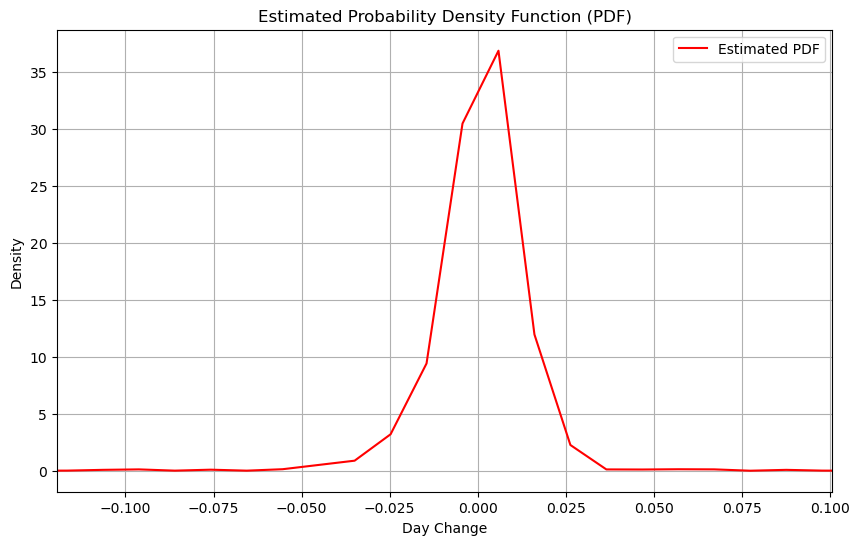

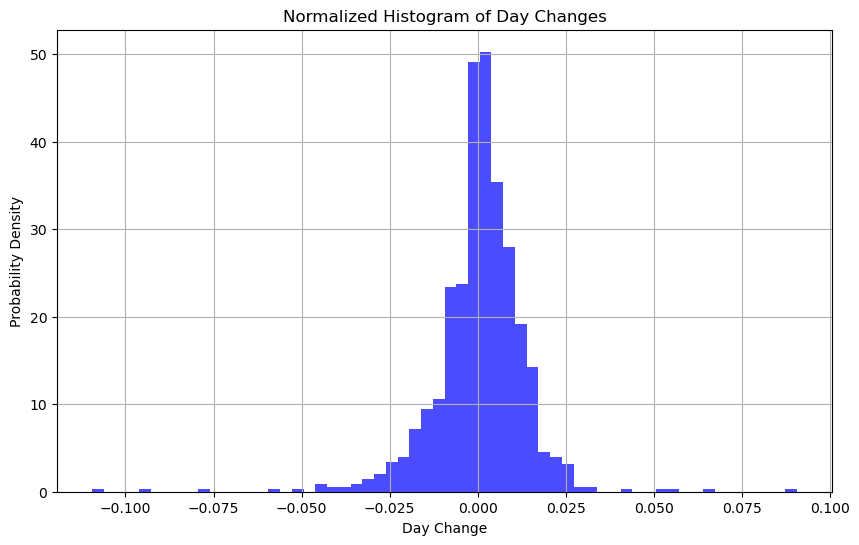

The integral of the PDF is approximately: 0.9846985587707546
The integral of the normalized histogram is approximately: 1.0
The probability-weighted expected value (mean day change) is approximately: 0.0006609713217644093

You're on the right track! Integrating across the histogram can give you the actual counts or sums of values, while the integral of the PDF gives you probabilities. 
By combining these, you can get both the probability and the actual dollar (or percentage) values.




In [11]:
# Extract the 'day_change' column
day_change = data['day_change'].values

# Perform Kernel Density Estimation (KDE)
kde = gaussian_kde(day_change)

# Generate a range of values over which to evaluate the KDE
x = np.linspace(min(day_change) - 5, max(day_change) + 5, 1000)
pdf_vals = kde(x)

# Compute the integral of the PDF using Simpson's rule
integral = simps(pdf_vals, x)

# Plot the estimated PDF
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_vals, label='Estimated PDF', color='red')

# Set x-axis limits plt.xlim(min(day_change) - 5, max(day_change) + 5)
plt.xlim(min(day_change) - .01, max(day_change) + .01)

plt.xlabel('Day Change')
plt.ylabel('Density')
plt.title('Estimated Probability Density Function (PDF)')
plt.legend()
plt.grid(True)
plt.show()

# Drop NaN values from the DataFrame
data = data.dropna(subset=['day_change'])

# Extract the 'day_change' column
day_change = data['day_change'].values

# Create the normalized histogram
counts, bin_edges = np.histogram(day_change, bins=30, density=True)

# Compute the integral of the normalized histogram (should be 1)
integral_normalized_histogram = np.sum(counts * np.diff(bin_edges))


# Calculate the midpoints of bins for expected value computation
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

# Compute the probability-weighted average (expected value)
expected_value = np.sum(counts * bin_midpoints * np.diff(bin_edges))

# Plot the normalized histogram
plt.figure(figsize=(10, 6))
plt.hist(day_change, bins=60, density=True, color='blue', alpha=0.7)  # density=True normalizes the histogram
plt.xlabel('Day Change')
plt.ylabel('Probability Density')
plt.title('Normalized Histogram of Day Changes')
plt.grid(True)
plt.show()

print(f"The integral of the PDF is approximately: {integral}")
print(f"The integral of the normalized histogram is approximately: {integral_normalized_histogram}")
print(f"The probability-weighted expected value (mean day change) is approximately: {expected_value}")


print('''
You're on the right track! Integrating across the histogram can give you the actual counts or sums of values, while the integral of the PDF gives you probabilities. 
By combining these, you can get both the probability and the actual dollar (or percentage) values.

''')


In [12]:
def get_expected_value_for_percentile(data, percentage):

    # Drop NaN values from the DataFrame
    data = data.dropna(subset=['day_change'])

    # Extract the 'day_change' column
    day_change = data['day_change'].values

    # Perform Kernel Density Estimation (KDE)
    kde = gaussian_kde(day_change)

    # Generate a range of values over which to evaluate the KDE
    x = np.linspace(min(day_change) - 5, max(day_change) + 5, 1000)
    pdf_vals = kde(x)

    # Compute the cumulative distribution function (CDF)
    cdf_vals = np.cumsum(pdf_vals) * np.diff(x, prepend=0)

    # Create an interpolation function for the CDF
    cdf_interp = interp1d(cdf_vals, x)

    # Find the day change value corresponding to the given percentage
    day_change_value = cdf_interp(percentage / 100.0)
    
    return day_change_value

# Example usage
percentage = 64  # input percentage
expected_value = get_expected_value_for_percentile(data, percentage)
print(f"The expected value for the {percentage}th percentile of day change is approximately: {expected_value}")

print('''

get_expected_value_for_percentile_range(data, 0, 64): This computes the average day change for the 0th to 64th percentile.
get_expected_value_for_percentage(data, 64): This finds the day change value exactly at the 64th percentile, not an average.

''')


The expected value for the 64th percentile of day change is approximately: 0.0006356106934689976


get_expected_value_for_percentile_range(data, 0, 64): This computes the average day change for the 0th to 64th percentile.
get_expected_value_for_percentage(data, 64): This finds the day change value exactly at the 64th percentile, not an average.




The expected value for the 0th to 94th percentile range of day change is approximately: -0.0026737817388582056
count    1050.000000
mean        0.000670
std         0.012905
min        -0.109424
25%        -0.004267
50%         0.001346
75%         0.007292
max         0.090603
Name: day_change, dtype: float64


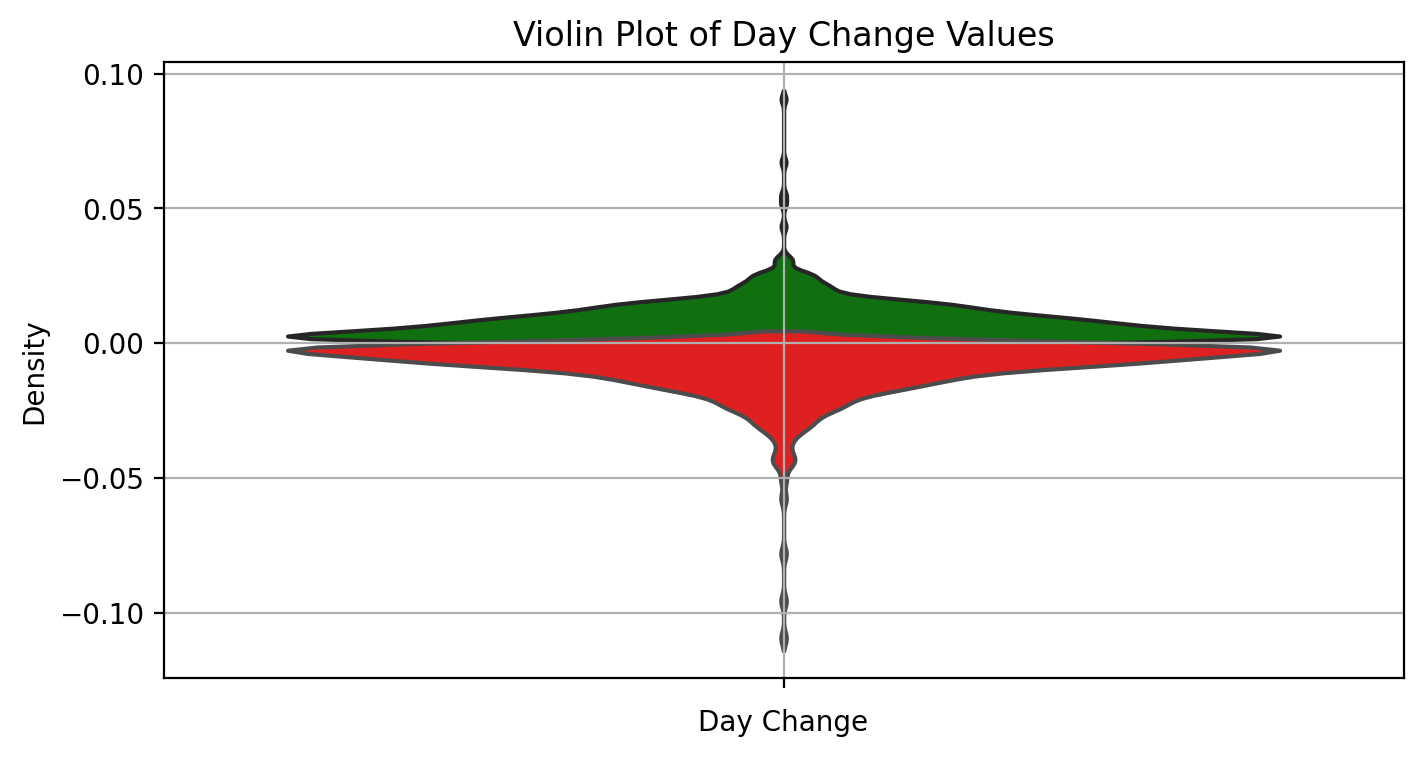

Proportion of positive days: 0.58
Proportion of negative days: 0.42


In [13]:
def get_expected_value_for_percentile_range(data, lower_percentage, upper_percentage):
    
    # Extract the 'day_change' column
    day_change = data['day_change'].values

    # Perform Kernel Density Estimation (KDE)
    kde = gaussian_kde(day_change)

    # Generate a range of values over which to evaluate the KDE
    x = np.linspace(min(day_change) - 5, max(day_change) + 5, 1000)
    pdf_vals = kde(x)

    # Compute the cumulative distribution function (CDF)
    cdf_vals = np.cumsum(pdf_vals) * np.diff(x, prepend=0)

    # Create an interpolation function for the CDF
    cdf_interp = interp1d(cdf_vals, x)

    # Find the day change values corresponding to the given percentiles
    lower_day_change_value = cdf_interp(lower_percentage / 100.0)
    upper_day_change_value = cdf_interp(upper_percentage / 100.0)

    # Calculate the expected value within the specified percentile range
    mask = (x >= lower_day_change_value) & (x <= upper_day_change_value)
    expected_value = np.sum(pdf_vals[mask] * x[mask]) / np.sum(pdf_vals[mask])
    
    return expected_value

# Example usage
lower_percentage = 0  # input lower percentage
upper_percentage = 94  # input upper percentage
expected_value_range = get_expected_value_for_percentile_range(data, lower_percentage, upper_percentage)
print(f"The expected value for the {lower_percentage}th to {upper_percentage}th percentile range of day change is approximately: {expected_value_range}")

# WHY ARE ALL THE VALUES NEGATIVE?
# Assuming your data is in a DataFrame called 'data'
# Replace the following line with your actual data loading process
# data = pd.read_csv('your_data.csv')

# Basic statistics of day_change
print(data['day_change'].describe())

# Splitting the data into positive and negative changes
positive_data = data[data['day_change'] >= 0]
negative_data = data[data['day_change'] < 0]

# Setting the figure size and resolution
plt.figure(figsize=(8, 4), dpi=200)

# Violin plot for positive changes
sns.violinplot(y=positive_data['day_change'], color='green', inner=None, bw=0.2)

# Violin plot for negative changes
sns.violinplot(y=negative_data['day_change'], color='red', inner=None, bw=0.2)

plt.xlabel('Day Change')
plt.ylabel('Density')
plt.title('Violin Plot of Day Change Values')
plt.grid(True)
plt.show()

# Proportion of positive and negative day changes
positive_days = np.sum(data['day_change'] > 0) / len(data['day_change'])
negative_days = np.sum(data['day_change'] < 0) / len(data['day_change'])
print(f"Proportion of positive days: {positive_days:.2f}")
print(f"Proportion of negative days: {negative_days:.2f}")


In [14]:
# Calculate the expected value (mean) using the whole distribution
expected_value_day_change = np.mean(data['day_change'])
expected_value_intraday_volatility = np.mean(data['Intraday_Volatility'])

Price_of_SPY= 581

# Calculate the expected premium
expected_premium_day_change = expected_value_day_change * Price_of_SPY
expected_premium_intraday_volatility = expected_value_intraday_volatility * Price_of_SPY

print(f"Expected Premium (day change) using whole distribution: {expected_premium_day_change}")
print(f"Expected Premium (Intraday Volatility) using whole distribution: {expected_premium_intraday_volatility}")


Expected Premium (day change) using whole distribution: 0.389177878625714
Expected Premium (Intraday Volatility) using whole distribution: 6.769055297400173


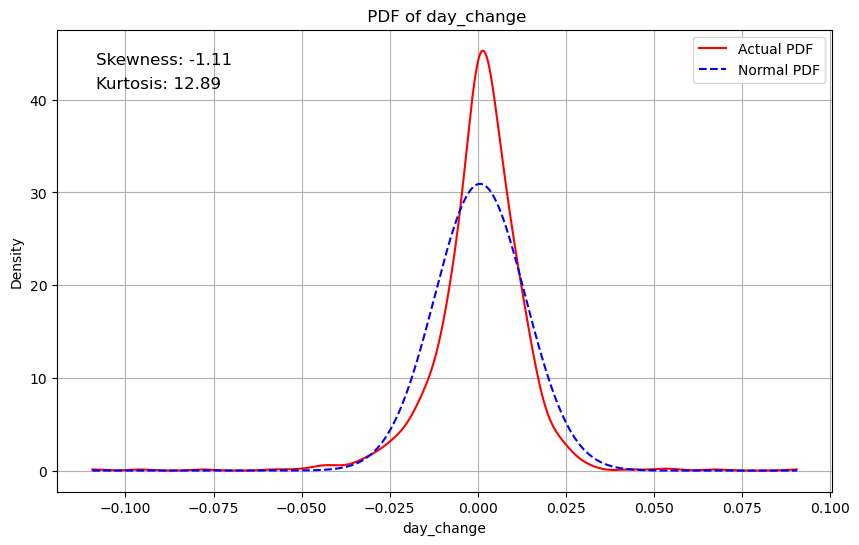

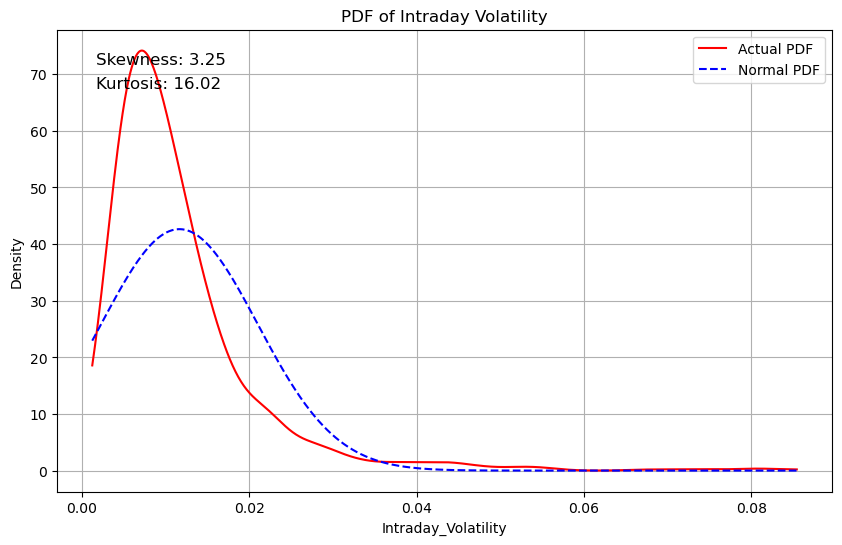


Yes, you're correct! Leptokurtosis in day-over-day returns implies a higher likelihood of extreme market movements, which translates to higher risk. This increased risk is often reflected in 
more expensive options premiums, including call options, as investors demand a premium for taking on the additional risk of potential extreme market fluctuations1



In [15]:
# Calculate PDF
pdf = gaussian_kde(data['day_change'])
x = np.linspace(min(data['day_change']), max(data['day_change']), 1000)
pdf_vals = pdf(x)

# Calculate the normal distribution PDF for comparison
mean = data['day_change'].mean()
std = data['day_change'].std()
normal_pdf = norm.pdf(x, mean, std)

# Calculate skewness and kurtosis
skewness_day_change = data['day_change'].skew()
kurtosis_day_change = data['day_change'].kurtosis()

# Plot PDF with normal distribution
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_vals, label='Actual PDF', color='red')
plt.plot(x, normal_pdf, label='Normal PDF', color='blue', linestyle='dashed')
plt.xlabel('day_change')
plt.ylabel('Density')
plt.title(' PDF of day_change')
plt.legend()
plt.grid(True)

# Add text labels for skewness and kurtosis
plt.text(0.05, 0.95, f'Skewness: {skewness_day_change:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'Kurtosis: {kurtosis_day_change:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()

# Drop NaNs from Intraday_Volatility
data = data.dropna(subset=['Intraday_Volatility'])

# Calculate PDF
pdf = gaussian_kde(data['Intraday_Volatility'])
x = np.linspace(min(data['Intraday_Volatility']), max(data['Intraday_Volatility']), 1000)
pdf_vals = pdf(x)

# Calculate the normal distribution PDF for comparison
mean = data['Intraday_Volatility'].mean()
std = data['Intraday_Volatility'].std()
normal_pdf = norm.pdf(x, mean, std)

# Calculate skewness and kurtosis
skewness_Intraday_Volatility = data['Intraday_Volatility'].skew()
kurtosis_Intraday_Volatility = data['Intraday_Volatility'].kurtosis()

# Plot PDF with normal distribution
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_vals, label='Actual PDF', color='red')
plt.plot(x, normal_pdf, label='Normal PDF', color='blue', linestyle='dashed')
plt.xlabel('Intraday_Volatility')
plt.ylabel('Density')
plt.title('PDF of Intraday Volatility')
plt.legend()
plt.grid(True)

# Add text labels for skewness and kurtosis
plt.text(0.05, 0.95, f'Skewness: {skewness_Intraday_Volatility:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'Kurtosis: {kurtosis_Intraday_Volatility:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()

print('''
Yes, you're correct! Leptokurtosis in day-over-day returns implies a higher likelihood of extreme market movements, which translates to higher risk. This increased risk is often reflected in 
more expensive options premiums, including call options, as investors demand a premium for taking on the additional risk of potential extreme market fluctuations1
''')


In [16]:
## Actual Gaps

data['High_shift'] = data['High'].shift(1)
data['Low_shift'] = data['Low'].shift(1)

# Define the opening gap with the condition
def calculate_opening_gaps(row):
    if row['Open'] > row['High_shift']:
        return (row['Open'] - row['High_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    elif row['Open'] < row['Low_shift']:
        return (row['Open'] - row['Low_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    else:
        return np.nan

# Apply the calculation function to each row
data['opening_gaps_2'] = data.apply(calculate_opening_gaps, axis=1)

# Drop the shifted columns if they're not needed
data.drop(columns=['High_shift', 'Low_shift'], inplace=True)

print(data[['Date', 'Open', 'High', 'Low', 'Close/Last', 'opening_gaps_2']].head())

print(data['opening_gaps_2'].count())


           Date    Open     High     Low  Close/Last  opening_gaps_2
2464 2014-11-25  207.54  207.790  206.80      207.11             NaN
2461 2014-12-01  206.40  206.540  205.38      205.76       -0.001941
2456 2014-12-08  207.52  208.120  205.93      206.61        0.004733
2455 2014-12-09  204.37  206.600  203.91      206.47       -0.007594
2452 2014-12-12  202.64  203.819  200.85      200.89       -0.006294
883


# <a id="section1"></a>Intraday Reversion to Yesterday's Close
[Back to Table of Contents](#table-of-contents)

                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     21.52
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           5.89e-06
Time:                        10:04:37   Log-Likelihood:                 779.46
No. Observations:                 230   AIC:                            -1555.
Df Residuals:                     228   BIC:                            -1548.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0008      0.002      0.445   

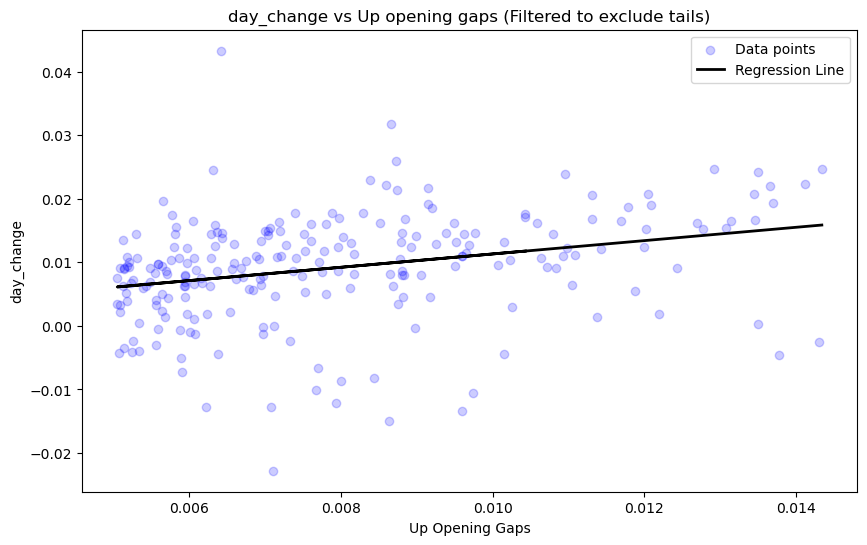

                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     9.499
Date:                Sat, 16 Nov 2024   Prob (F-statistic):            0.00239
Time:                        10:04:37   Log-Likelihood:                 588.02
No. Observations:                 178   AIC:                            -1172.
Df Residuals:                     176   BIC:                            -1166.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0014      0.002     -0.622   

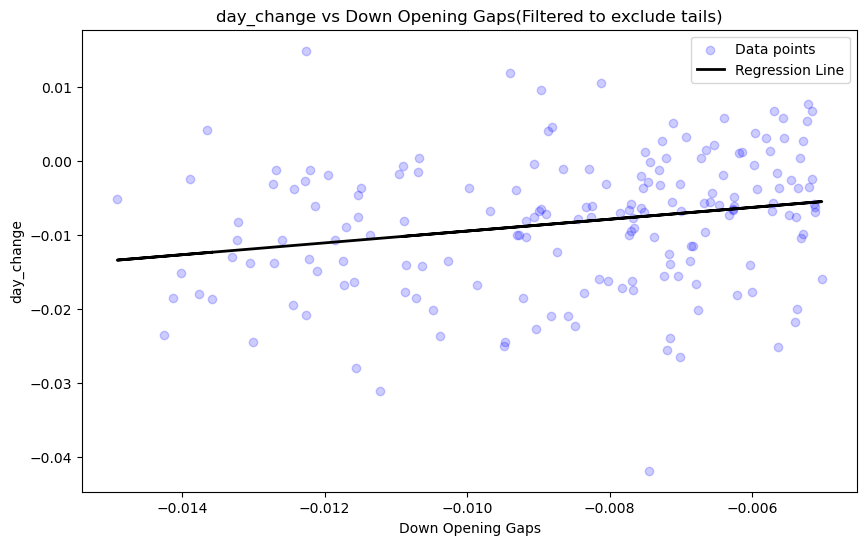



Yes, exactly. The coefficient of 0.6516 indicates that for down gaps, there's a tendency towards mean reversion. Essentially, if the opening gap is negative, the day's change only follows through 
by approximately 65% of the opening gap size. This suggests that the market tends to correct itself, rather than continuing to move in the same direction as the initial gap.

The data points and your regression analysis are supporting the notion that down gaps demonstrate a mean reversion effect, while up gaps don't follow the same pattern as closely.




Spot on. The coefficient of approximately 1.0681 indeed suggests that the day change is closely tied to the opening gap, which means that on days with positive opening gaps, the day change tends 
to match the magnitude of the gap. 
This implies that, for these positive gaps within the specified range, the closing price doesn't revert to the previous day's close





In [17]:
# Filter the DataFrame to include only positive opening gaps greater than 0.005 and less than 0.05
filtered_data = data[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] <= 0.015)]

# Fit the regression model with opening_gaps driving Open_minus_Low
X = filtered_data['opening_gaps']
y = filtered_data['day_change']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['opening_gaps'], filtered_data['day_change'], color='blue', alpha=0.2, label='Data points')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Up Opening Gaps')
plt.ylabel('day_change')
plt.title('day_change vs Up opening gaps (Filtered to exclude tails)')

# Add legend
plt.legend()

# Show and save the plot
plt.show()




# Filter the DataFrame to include only positive opening gaps greater than 0.005 and less than 0.05
filtered_data = data[(data['opening_gaps'] < -0.005) & (data['opening_gaps'] >= -0.015)]

# Fit the regression model with opening_gaps driving Open_minus_Low
X = filtered_data['opening_gaps']
y = filtered_data['day_change']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['opening_gaps'], filtered_data['day_change'], color='blue', alpha=0.2, label='Data points')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Down Opening Gaps')
plt.ylabel('day_change')
plt.title('day_change vs Down Opening Gaps(Filtered to exclude tails)')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

print('''

Yes, exactly. The coefficient of 0.6516 indicates that for down gaps, there's a tendency towards mean reversion. Essentially, if the opening gap is negative, the day's change only follows through 
by approximately 65% of the opening gap size. This suggests that the market tends to correct itself, rather than continuing to move in the same direction as the initial gap.

The data points and your regression analysis are supporting the notion that down gaps demonstrate a mean reversion effect, while up gaps don't follow the same pattern as closely.

''')


print('''

Spot on. The coefficient of approximately 1.0681 indeed suggests that the day change is closely tied to the opening gap, which means that on days with positive opening gaps, the day change tends 
to match the magnitude of the gap. 
This implies that, for these positive gaps within the specified range, the closing price doesn't revert to the previous day's close


''')


                                     OLS Regression Results                                     
Dep. Variable:     day_change_adjusted_for_openning_gap   R-squared:                       0.000
Model:                                              OLS   Adj. R-squared:                 -0.004
Method:                                   Least Squares   F-statistic:                   0.04723
Date:                                  Sat, 16 Nov 2024   Prob (F-statistic):              0.828
Time:                                          10:04:37   Log-Likelihood:                 779.46
No. Observations:                                   230   AIC:                            -1555.
Df Residuals:                                       228   BIC:                            -1548.
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
                   coef    std

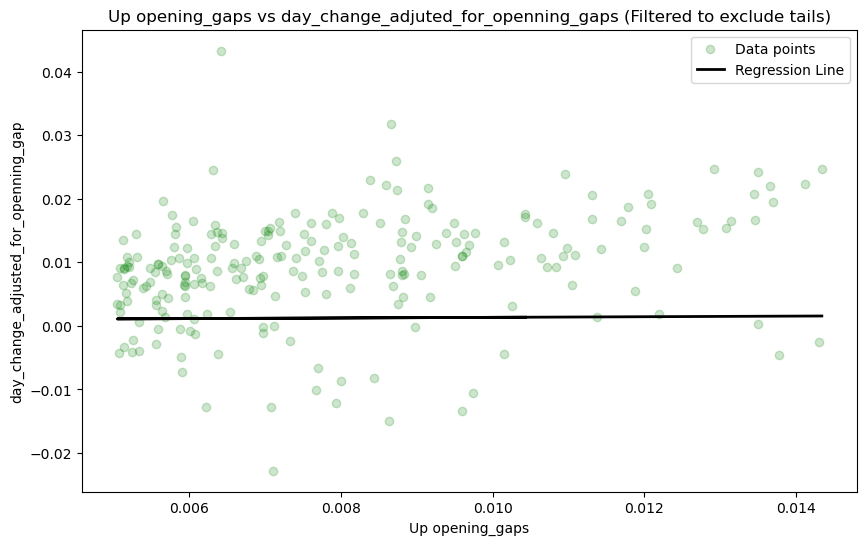

                                     OLS Regression Results                                     
Dep. Variable:     day_change_adjusted_for_openning_gap   R-squared:                       0.003
Model:                                              OLS   Adj. R-squared:                 -0.002
Method:                                   Least Squares   F-statistic:                    0.5985
Date:                                  Sat, 16 Nov 2024   Prob (F-statistic):              0.440
Time:                                          10:04:37   Log-Likelihood:                 588.02
No. Observations:                                   178   AIC:                            -1172.
Df Residuals:                                       176   BIC:                            -1166.
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
                   coef    std

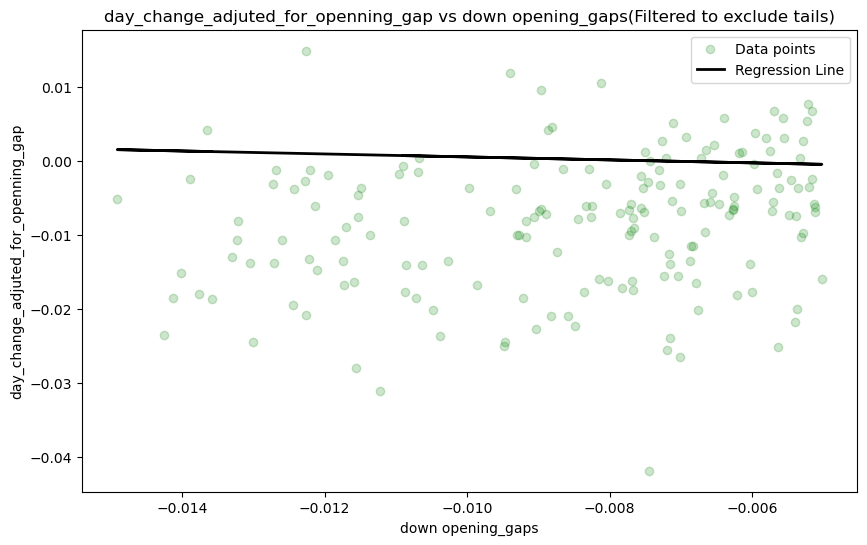



This doesn'tt answer the question of mean reversion at all, because you're setting the adjusted open as the Y-value




In [18]:
# Filter the DataFrame to include only positive opening gaps greater than 0.005 and less than 0.05
filtered_data = data[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] <= 0.015)]

# Fit the regression model with opening_gaps driving Open_minus_Low
X = filtered_data['opening_gaps']
y = filtered_data['day_change_adjusted_for_openning_gap']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['opening_gaps'], filtered_data['day_change'], color='green', alpha=0.2, label='Data points')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Up opening_gaps')
plt.ylabel('day_change_adjusted_for_openning_gap')
plt.title('Up opening_gaps vs day_change_adjuted_for_openning_gaps (Filtered to exclude tails)')

# Add legend
plt.legend()

# Show and save the plot
plt.show()



# Filter the DataFrame to include only positive opening gaps greater than 0.005 and less than 0.05
filtered_data = data[(data['opening_gaps'] < -0.005) & (data['opening_gaps'] >= -0.015)]

# Fit the regression model with opening_gaps driving Open_minus_Low
X = filtered_data['opening_gaps']
y = filtered_data['day_change_adjusted_for_openning_gap']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['opening_gaps'], filtered_data['day_change'], color='green', alpha=0.2, label='Data points')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('down opening_gaps')
plt.ylabel('day_change_adjuted_for_openning_gap')
plt.title('day_change_adjuted_for_openning_gap vs down opening_gaps(Filtered to exclude tails)')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

print('''

This doesn'tt answer the question of mean reversion at all, because you're setting the adjusted open as the Y-value

''')

# <a id="section4"></a> Opening Gaps and Intraday Volatility
[Back to Table of Contents](#table-of-contents)


                             OLS Regression Results                            
Dep. Variable:     Intraday_Volatility   R-squared:                       0.066
Model:                             OLS   Adj. R-squared:                  0.059
Method:                  Least Squares   F-statistic:                     8.305
Date:                 Sun, 17 Nov 2024   Prob (F-statistic):            0.00465
Time:                         08:59:33   Log-Likelihood:                 462.16
No. Observations:                  128   AIC:                            -920.3
Df Residuals:                      126   BIC:                            -914.6
Df Model:                            1                                         
Covariance Type:                   HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0035      0.003    

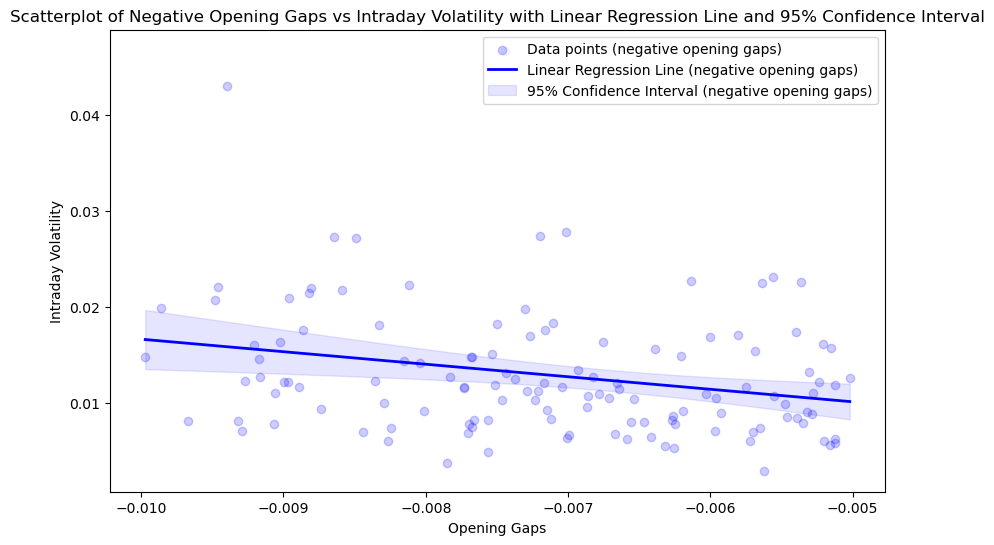

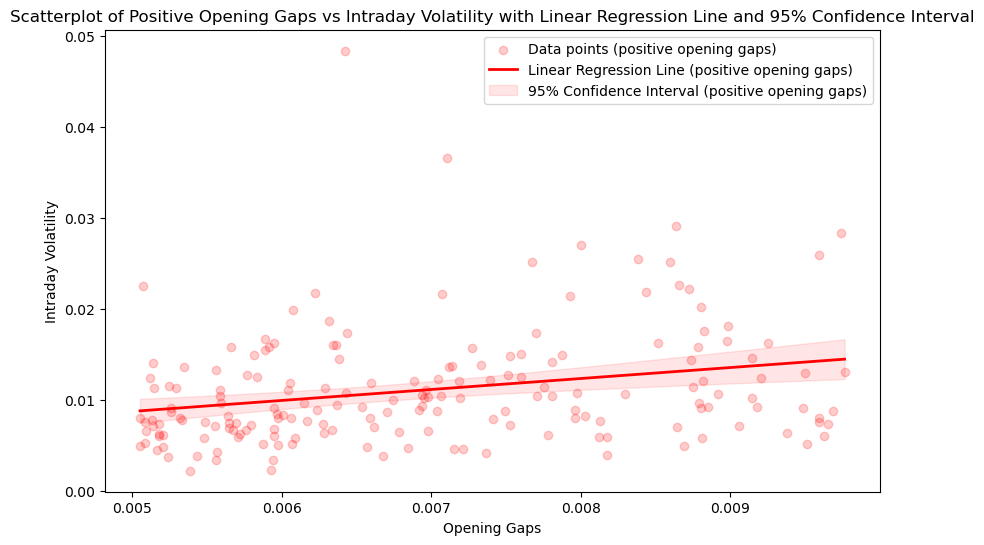

Negative Opening Gaps - Lagrange multiplier statistic: 1.727336693275987
Negative Opening Gaps - p-value: 0.18875138409607334
Positive Opening Gaps - Lagrange multiplier statistic: 1.0296099515283998
Positive Opening Gaps - p-value: 0.31025029643859786

Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.

Reducing the gap range to .5% to 1% fixes the heteroskedasticity issue.



In [42]:
# Filter the DataFrame based on the specified criteria and intraday volatility
filtered_data_below = data.loc[(data['opening_gaps'] > -0.01) & (data['opening_gaps'] < -0.005) & (data['Intraday_Volatility'] <= 0.05)].copy()
filtered_data_above = data.loc[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] < 0.01) & (data['Intraday_Volatility'] <= 0.05)].copy()

# First regression (below -0.005 and greater than -0.02)
X_below = filtered_data_below['opening_gaps']
X_below = sm.add_constant(X_below)  # Adds a constant term to the predictor

y_below = filtered_data_below['Intraday_Volatility']

# Fit the model with RBSE
model_below = sm.OLS(y_below, X_below).fit(cov_type='HC3')

# Print the OLS results
print(model_below.summary())

# Predict values and get confidence intervals
predictions_below = model_below.get_prediction(X_below)
predictions_below_summary = predictions_below.summary_frame(alpha=0.05)
predicted_mean_below = predictions_below_summary['mean']
conf_int_below_lower = predictions_below_summary['mean_ci_lower']
conf_int_below_upper = predictions_below_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_below = np.argsort(filtered_data_below['opening_gaps'])
sorted_opening_gaps_below = filtered_data_below['opening_gaps'].values[sorted_idx_below]
sorted_conf_int_below_lower = conf_int_below_lower.values[sorted_idx_below]
sorted_conf_int_below_upper = conf_int_below_upper.values[sorted_idx_below]
sorted_predicted_mean_below = predicted_mean_below.values[sorted_idx_below]

# Second regression (greater than 0.005 and less than 0.02)
X_above = filtered_data_above['opening_gaps']
X_above = sm.add_constant(X_above)  # Adds a constant term to the predictor

y_above = filtered_data_above['Intraday_Volatility']

# Fit the model with RBSE
model_above = sm.OLS(y_above, X_above).fit(cov_type='HC3')

# Print the OLS results
print(model_above.summary())

# Predict values and get confidence intervals
predictions_above = model_above.get_prediction(X_above)
predictions_above_summary = predictions_above.summary_frame(alpha=0.05)
predicted_mean_above = predictions_above_summary['mean']
conf_int_above_lower = predictions_above_summary['mean_ci_lower']
conf_int_above_upper = predictions_above_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_above = np.argsort(filtered_data_above['opening_gaps'])
sorted_opening_gaps_above = filtered_data_above['opening_gaps'].values[sorted_idx_above]
sorted_conf_int_above_lower = conf_int_above_lower.values[sorted_idx_above]
sorted_conf_int_above_upper = conf_int_above_upper.values[sorted_idx_above]
sorted_predicted_mean_above = predicted_mean_above.values[sorted_idx_above]

# Create the scatter plot for negative opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the first regression
plt.scatter(filtered_data_below['opening_gaps'], filtered_data_below['Intraday_Volatility'], 
                             color='blue', alpha=0.2, label='Data points (negative opening gaps)')

# Plot the linear regression line for the first regression
plt.plot(sorted_opening_gaps_below, sorted_predicted_mean_below, color='blue', linewidth=2, label='Linear Regression Line (negative opening gaps)')

# Plot the confidence intervals for the first regression
plt.fill_between(sorted_opening_gaps_below, sorted_conf_int_below_lower, sorted_conf_int_below_upper, color='blue', alpha=0.1, label='95% Confidence Interval (negative opening gaps)')

# Add labels and title
plt.xlabel('Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Negative Opening Gaps vs Intraday Volatility with Linear Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Create the scatter plot for positive opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the second regression
plt.scatter(filtered_data_above['opening_gaps'], filtered_data_above['Intraday_Volatility'], 
                             color='red', alpha=0.2, label='Data points (positive opening gaps)')

# Plot the linear regression line for the second regression
plt.plot(sorted_opening_gaps_above, sorted_predicted_mean_above, color='red', linewidth=2, label='Linear Regression Line (positive opening gaps)')

# Plot the confidence intervals for the second regression
plt.fill_between(sorted_opening_gaps_above, sorted_conf_int_above_lower, sorted_conf_int_above_upper, color='red', alpha=0.1, label='95% Confidence Interval (positive opening gaps)')

# Add labels and title
plt.xlabel('Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Positive Opening Gaps vs Intraday Volatility with Linear Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Perform the Breusch-Pagan test for the first regression
test_below = sms.het_breuschpagan(model_below.resid, model_below.model.exog)
print(f'Negative Opening Gaps - Lagrange multiplier statistic: {test_below[0]}')
print(f'Negative Opening Gaps - p-value: {test_below[1]}')

# Perform the Breusch-Pagan test for the second regression
test_above = sms.het_breuschpagan(model_above.resid, model_above.model.exog)
print(f'Positive Opening Gaps - Lagrange multiplier statistic: {test_above[0]}')
print(f'Positive Opening Gaps - p-value: {test_above[1]}')

print('''
Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.

Reducing the gap range to .5% to 1% fixes the heteroskedasticity issue.
''')


                             OLS Regression Results                            
Dep. Variable:     Intraday_Volatility   R-squared:                       0.063
Model:                             OLS   Adj. R-squared:                  0.055
Method:                  Least Squares   F-statistic:                     8.289
Date:                 Sat, 16 Nov 2024   Prob (F-statistic):            0.00469
Time:                         18:19:20   Log-Likelihood:                 461.92
No. Observations:                  128   AIC:                            -919.8
Df Residuals:                      126   BIC:                            -914.1
Df Model:                            1                                         
Covariance Type:                   HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 

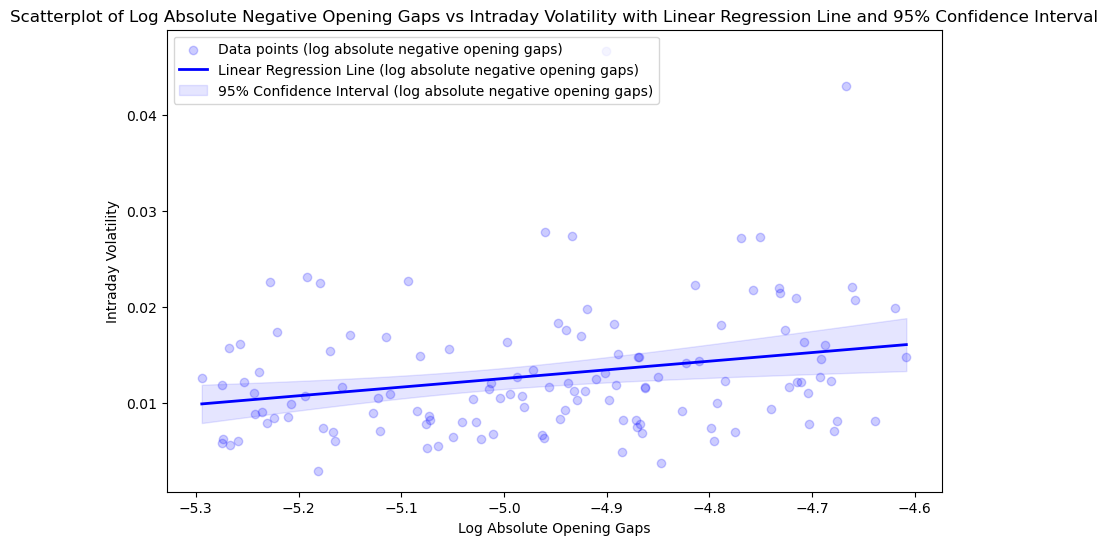

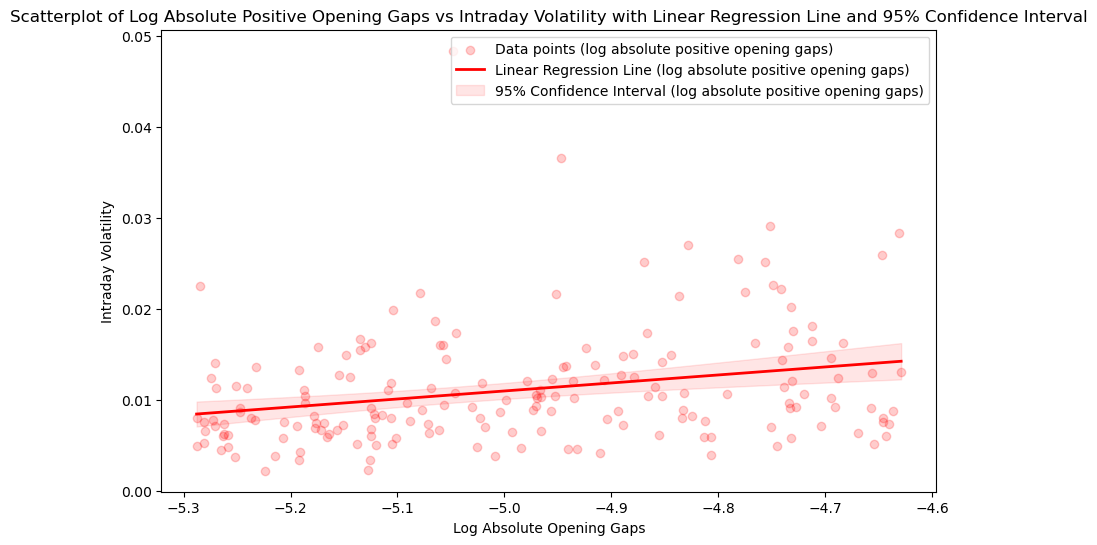

Negative Opening Gaps - Lagrange multiplier statistic: 1.7438683253614045
Negative Opening Gaps - p-value: 0.18664942984862312
Positive Opening Gaps - Lagrange multiplier statistic: 1.1757371682641224
Positive Opening Gaps - p-value: 0.2782255350712444
 

Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.




In [37]:
# Filter the DataFrame based on the specified criteria and intraday volatility
filtered_data_below = data.loc[(data['opening_gaps'] > -0.01) & (data['opening_gaps'] < -0.005) & (data['Intraday_Volatility'] <= 0.05)].copy()
filtered_data_above = data.loc[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] < 0.01) & (data['Intraday_Volatility'] <= 0.05)].copy()

# Apply log transformation using the absolute values
filtered_data_below['log_abs_opening_gaps'] = np.log(np.abs(filtered_data_below['opening_gaps']))
filtered_data_above['log_abs_opening_gaps'] = np.log(filtered_data_above['opening_gaps'])

# First regression (below -0.005 and greater than -0.02)
X_below = filtered_data_below['log_abs_opening_gaps']
X_below = sm.add_constant(X_below)  # Adds a constant term to the predictor

y_below = filtered_data_below['Intraday_Volatility']

# Fit the model with RBSE
model_below = sm.OLS(y_below, X_below).fit(cov_type='HC3')

# Print the OLS results
print(model_below.summary())

# Predict values and get confidence intervals
predictions_below = model_below.get_prediction(X_below)
predictions_below_summary = predictions_below.summary_frame(alpha=0.05)
predicted_mean_below = predictions_below_summary['mean']
conf_int_below_lower = predictions_below_summary['mean_ci_lower']
conf_int_below_upper = predictions_below_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_below = np.argsort(filtered_data_below['log_abs_opening_gaps'])
sorted_log_abs_opening_gaps_below = filtered_data_below['log_abs_opening_gaps'].values[sorted_idx_below]
sorted_conf_int_below_lower = conf_int_below_lower.values[sorted_idx_below]
sorted_conf_int_below_upper = conf_int_below_upper.values[sorted_idx_below]
sorted_predicted_mean_below = predicted_mean_below.values[sorted_idx_below]

# Second regression (greater than 0.005 and less than 0.02)
X_above = filtered_data_above['log_abs_opening_gaps']
X_above = sm.add_constant(X_above)  # Adds a constant term to the predictor

y_above = filtered_data_above['Intraday_Volatility']

# Fit the model with RBSE
model_above = sm.OLS(y_above, X_above).fit(cov_type='HC3')

# Print the OLS results
print(model_above.summary())

# Predict values and get confidence intervals
predictions_above = model_above.get_prediction(X_above)
predictions_above_summary = predictions_above.summary_frame(alpha=0.05)
predicted_mean_above = predictions_above_summary['mean']
conf_int_above_lower = predictions_above_summary['mean_ci_lower']
conf_int_above_upper = predictions_above_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_above = np.argsort(filtered_data_above['log_abs_opening_gaps'])
sorted_log_abs_opening_gaps_above = filtered_data_above['log_abs_opening_gaps'].values[sorted_idx_above]
sorted_conf_int_above_lower = conf_int_above_lower.values[sorted_idx_above]
sorted_conf_int_above_upper = conf_int_above_upper.values[sorted_idx_above]
sorted_predicted_mean_above = predicted_mean_above.values[sorted_idx_above]

# Create the scatter plot for negative opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the first regression
plt.scatter(filtered_data_below['log_abs_opening_gaps'], filtered_data_below['Intraday_Volatility'], 
                             color='blue', alpha=0.2, label='Data points (log absolute negative opening gaps)')

# Plot the linear regression line for the first regression
plt.plot(sorted_log_abs_opening_gaps_below, sorted_predicted_mean_below, color='blue', linewidth=2, label='Linear Regression Line (log absolute negative opening gaps)')

# Plot the confidence intervals for the first regression
plt.fill_between(sorted_log_abs_opening_gaps_below, sorted_conf_int_below_lower, sorted_conf_int_below_upper, color='blue', alpha=0.1, label='95% Confidence Interval (log absolute negative opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Log Absolute Negative Opening Gaps vs Intraday Volatility with Linear Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Create the scatter plot for positive opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the second regression
plt.scatter(filtered_data_above['log_abs_opening_gaps'], filtered_data_above['Intraday_Volatility'], 
                             color='red', alpha=0.2, label='Data points (log absolute positive opening gaps)')

# Plot the linear regression line for the second regression
plt.plot(sorted_log_abs_opening_gaps_above, sorted_predicted_mean_above, color='red', linewidth=2, label='Linear Regression Line (log absolute positive opening gaps)')

# Plot the confidence intervals for the second regression
plt.fill_between(sorted_log_abs_opening_gaps_above, sorted_conf_int_above_lower, sorted_conf_int_above_upper, color='red', alpha=0.1, label='95% Confidence Interval (log absolute positive opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Log Absolute Positive Opening Gaps vs Intraday Volatility with Linear Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Perform the Breusch-Pagan test for the first regression
test_below = sms.het_breuschpagan(model_below.resid, model_below.model.exog)
print(f'Negative Opening Gaps - Lagrange multiplier statistic: {test_below[0]}')
print(f'Negative Opening Gaps - p-value: {test_below[1]}')

# Perform the Breusch-Pagan test for the second regression
test_above = sms.het_breuschpagan(model_above.resid, model_above.model.exog)
print(f'Positive Opening Gaps - Lagrange multiplier statistic: {test_above[0]}')
print(f'Positive Opening Gaps - p-value: {test_above[1]}')

print(''' 

Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.

redcing the gap range to .5% to 1% fixes the heteroskedasticty issue.

''')


                             OLS Regression Results                            
Dep. Variable:     Intraday_Volatility   R-squared:                       0.088
Model:                             OLS   Adj. R-squared:                  0.078
Method:                  Least Squares   F-statistic:                     9.027
Date:                 Sun, 17 Nov 2024   Prob (F-statistic):           0.000186
Time:                         08:54:10   Log-Likelihood:                 626.94
No. Observations:                  178   AIC:                            -1248.
Df Residuals:                      175   BIC:                            -1238.
Df Model:                            2                                         
Covariance Type:                   HC3                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const 

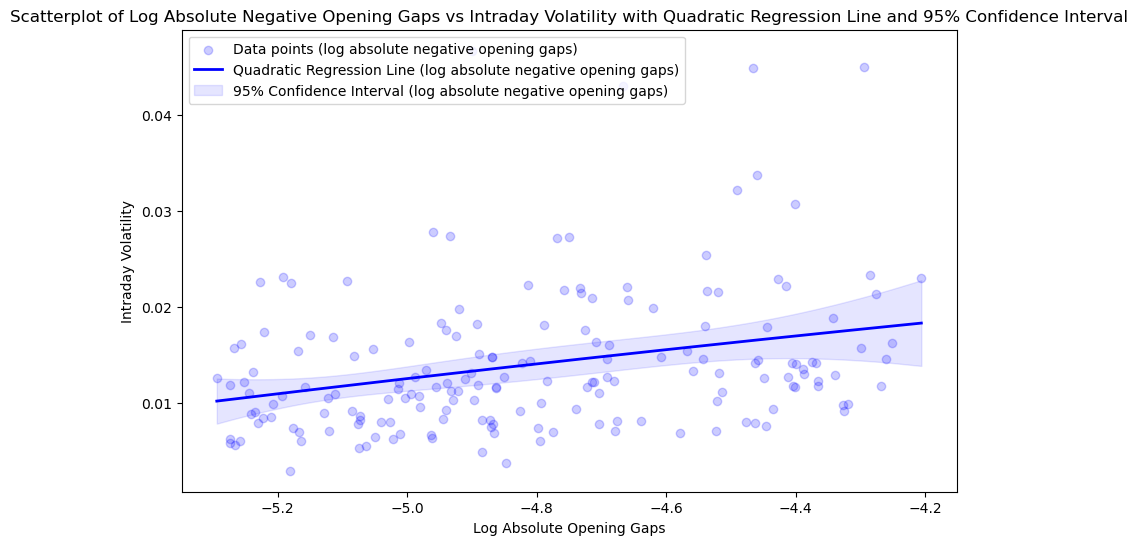

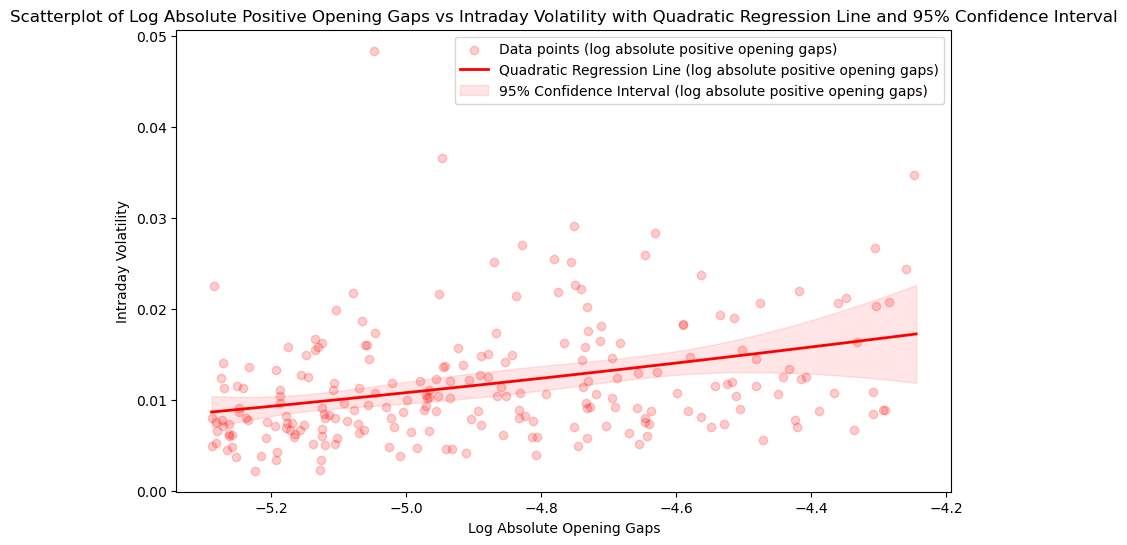

Negative Opening Gaps - Lagrange multiplier statistic: 3.1442897783302355
Negative Opening Gaps - p-value: 0.20759942671864087
Positive Opening Gaps - Lagrange multiplier statistic: 3.3741599292182753
Positive Opening Gaps - p-value: 0.18505911496231076

Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.

Reducing the gap range to .5% to 1% fixes the heteroskedasticity issue.



In [39]:
# Filter the DataFrame based on the specified criteria and intraday volatility
filtered_data_below = data.loc[(data['opening_gaps'] > -0.015) & (data['opening_gaps'] < -0.005) & (data['Intraday_Volatility'] <= 0.05)].copy()
filtered_data_above = data.loc[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] < 0.015) & (data['Intraday_Volatility'] <= 0.05)].copy()

# Apply log transformation using the absolute values
filtered_data_below['log_abs_opening_gaps'] = np.log(np.abs(filtered_data_below['opening_gaps']))
filtered_data_above['log_abs_opening_gaps'] = np.log(filtered_data_above['opening_gaps'])

# Add quadratic term for the first regression
filtered_data_below['log_abs_opening_gaps_squared'] = filtered_data_below['log_abs_opening_gaps'] ** 2

X_below = filtered_data_below[['log_abs_opening_gaps', 'log_abs_opening_gaps_squared']]
X_below = sm.add_constant(X_below)  # Adds a constant term to the predictor

y_below = filtered_data_below['Intraday_Volatility']

# Fit the model with RBSE
model_below = sm.OLS(y_below, X_below).fit(cov_type='HC3')

# Print the OLS results
print(model_below.summary())

# Predict values and get confidence intervals
predictions_below = model_below.get_prediction(X_below)
predictions_below_summary = predictions_below.summary_frame(alpha=0.05)
predicted_mean_below = predictions_below_summary['mean']
conf_int_below_lower = predictions_below_summary['mean_ci_lower']
conf_int_below_upper = predictions_below_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_below = np.argsort(filtered_data_below['log_abs_opening_gaps'])
sorted_log_abs_opening_gaps_below = filtered_data_below['log_abs_opening_gaps'].values[sorted_idx_below]
sorted_conf_int_below_lower = conf_int_below_lower.values[sorted_idx_below]
sorted_conf_int_below_upper = conf_int_below_upper.values[sorted_idx_below]
sorted_predicted_mean_below = predicted_mean_below.values[sorted_idx_below]

# Add quadratic term for the second regression
filtered_data_above['log_abs_opening_gaps_squared'] = filtered_data_above['log_abs_opening_gaps'] ** 2

X_above = filtered_data_above[['log_abs_opening_gaps', 'log_abs_opening_gaps_squared']]
X_above = sm.add_constant(X_above)  # Adds a constant term to the predictor

y_above = filtered_data_above['Intraday_Volatility']

# Fit the model with RBSE
model_above = sm.OLS(y_above, X_above).fit(cov_type='HC3')

# Print the OLS results
print(model_above.summary())

# Predict values and get confidence intervals
predictions_above = model_above.get_prediction(X_above)
predictions_above_summary = predictions_above.summary_frame(alpha=0.05)
predicted_mean_above = predictions_above_summary['mean']
conf_int_above_lower = predictions_above_summary['mean_ci_lower']
conf_int_above_upper = predictions_above_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_above = np.argsort(filtered_data_above['log_abs_opening_gaps'])
sorted_log_abs_opening_gaps_above = filtered_data_above['log_abs_opening_gaps'].values[sorted_idx_above]
sorted_conf_int_above_lower = conf_int_above_lower.values[sorted_idx_above]
sorted_conf_int_above_upper = conf_int_above_upper.values[sorted_idx_above]
sorted_predicted_mean_above = predicted_mean_above.values[sorted_idx_above]

# Create the scatter plot for negative opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the first regression
plt.scatter(filtered_data_below['log_abs_opening_gaps'], filtered_data_below['Intraday_Volatility'], 
                             color='blue', alpha=0.2, label='Data points (log absolute negative opening gaps)')

# Plot the quadratic regression line for the first regression
plt.plot(sorted_log_abs_opening_gaps_below, sorted_predicted_mean_below, color='blue', linewidth=2, label='Quadratic Regression Line (log absolute negative opening gaps)')

# Plot the confidence intervals for the first regression
plt.fill_between(sorted_log_abs_opening_gaps_below, sorted_conf_int_below_lower, sorted_conf_int_below_upper, color='blue', alpha=0.1, label='95% Confidence Interval (log absolute negative opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Log Absolute Negative Opening Gaps vs Intraday Volatility with Quadratic Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Create the scatter plot for positive opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the second regression
plt.scatter(filtered_data_above['log_abs_opening_gaps'], filtered_data_above['Intraday_Volatility'], 
                             color='red', alpha=0.2, label='Data points (log absolute positive opening gaps)')

# Plot the quadratic regression line for the second regression
plt.plot(sorted_log_abs_opening_gaps_above, sorted_predicted_mean_above, color='red', linewidth=2, label='Quadratic Regression Line (log absolute positive opening gaps)')

# Plot the confidence intervals for the second regression
plt.fill_between(sorted_log_abs_opening_gaps_above, sorted_conf_int_above_lower, sorted_conf_int_above_upper, color='red', alpha=0.1, label='95% Confidence Interval (log absolute positive opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Log Absolute Positive Opening Gaps vs Intraday Volatility with Quadratic Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Perform the Breusch-Pagan test for the first regression
test_below = sms.het_breuschpagan(model_below.resid, model_below.model.exog)
print(f'Negative Opening Gaps - Lagrange multiplier statistic: {test_below[0]}')
print(f'Negative Opening Gaps - p-value: {test_below[1]}')

# Perform the Breusch-Pagan test for the second regression
test_above = sms.het_breuschpagan(model_above.resid, model_above.model.exog)
print(f'Positive Opening Gaps - Lagrange multiplier statistic: {test_above[0]}')
print(f'Positive Opening Gaps - p-value: {test_above[1]}')

print('''
Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.

Reducing the gap range to .5% to 1% fixes the heteroskedasticity issue.
''')


                             OLS Regression Results                            
Dep. Variable:     Intraday_Volatility   R-squared:                       0.088
Model:                             OLS   Adj. R-squared:                  0.083
Method:                  Least Squares   F-statistic:                     16.95
Date:                 Sun, 17 Nov 2024   Prob (F-statistic):           5.89e-05
Time:                         08:57:08   Log-Likelihood:                 626.94
No. Observations:                  178   AIC:                            -1250.
Df Residuals:                      176   BIC:                            -1244.
Df Model:                            1                                         
Covariance Type:                   HC3                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const 

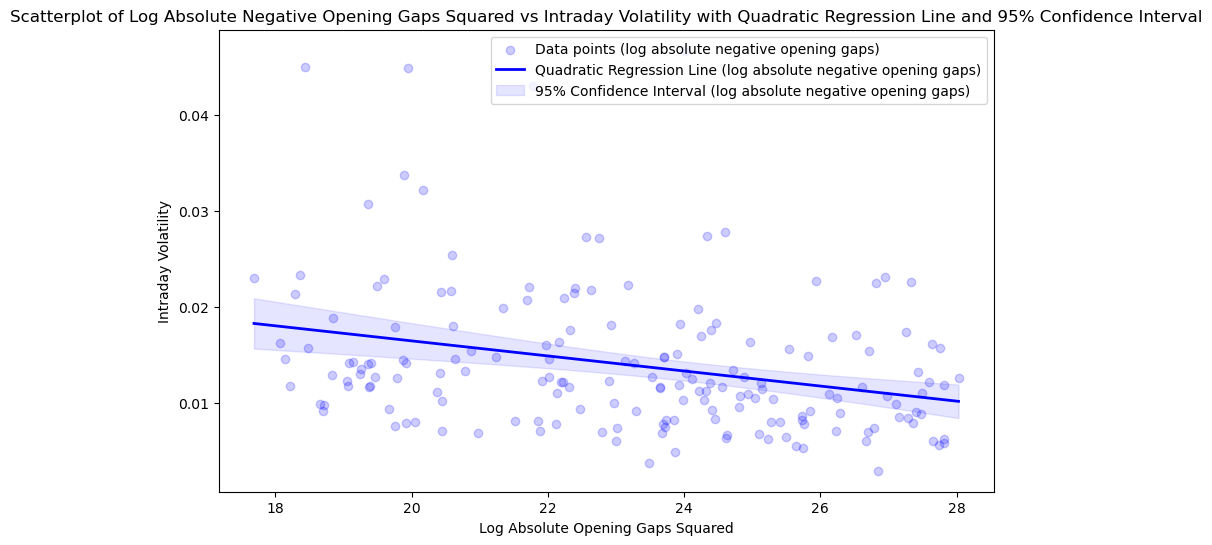

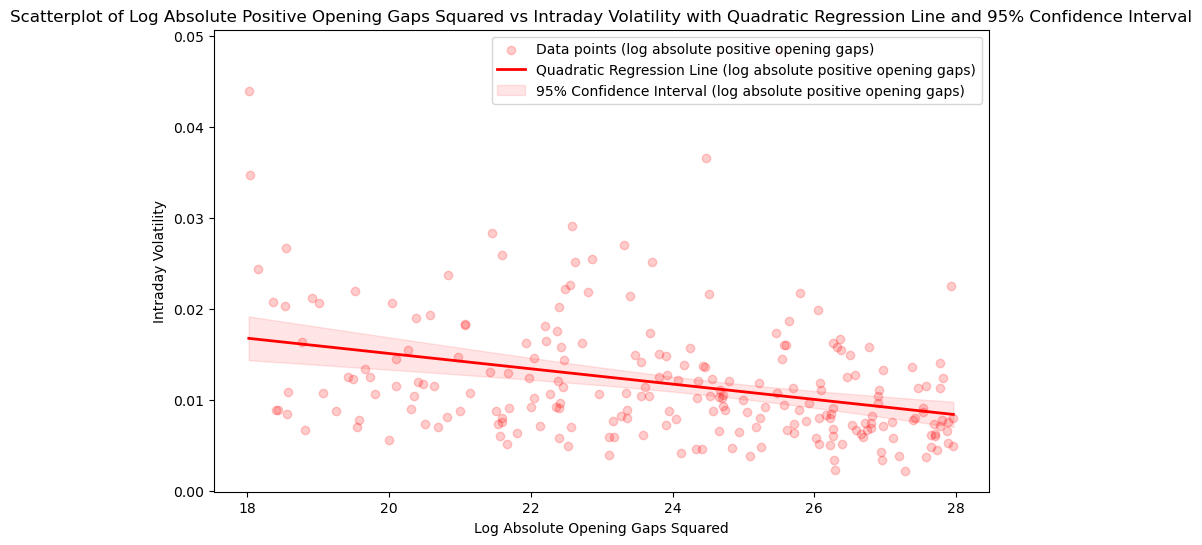

Negative Opening Gaps - Lagrange multiplier statistic: 3.0323194599512284
Negative Opening Gaps - p-value: 0.08162125907706294
Positive Opening Gaps - Lagrange multiplier statistic: 3.025723064140433
Positive Opening Gaps - p-value: 0.08195378261564833

Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.

Reducing the gap range to .5% to 1% fixes the heteroskedasticity issue.



In [41]:
# Filter the DataFrame based on the specified criteria and intraday volatility
filtered_data_below = data.loc[(data['opening_gaps'] > -0.015) & (data['opening_gaps'] < -0.005) & (data['Intraday_Volatility'] <= 0.05)].copy()
filtered_data_above = data.loc[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] < 0.015) & (data['Intraday_Volatility'] <= 0.05)].copy()

# Apply log transformation using the absolute values
filtered_data_below['log_abs_opening_gaps'] = np.log(np.abs(filtered_data_below['opening_gaps']))
filtered_data_above['log_abs_opening_gaps'] = np.log(filtered_data_above['opening_gaps'])

# Add quadratic term for the first regression
filtered_data_below['log_abs_opening_gaps_squared'] = filtered_data_below['log_abs_opening_gaps'] ** 2

X_below = filtered_data_below[['log_abs_opening_gaps_squared']]
X_below = sm.add_constant(X_below)  # Adds a constant term to the predictor

y_below = filtered_data_below['Intraday_Volatility']

# Fit the model with RBSE
model_below = sm.OLS(y_below, X_below).fit(cov_type='HC3')

# Print the OLS results
print(model_below.summary())

# Predict values and get confidence intervals
predictions_below = model_below.get_prediction(X_below)
predictions_below_summary = predictions_below.summary_frame(alpha=0.05)
predicted_mean_below = predictions_below_summary['mean']
conf_int_below_lower = predictions_below_summary['mean_ci_lower']
conf_int_below_upper = predictions_below_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_below = np.argsort(filtered_data_below['log_abs_opening_gaps_squared'])
sorted_log_abs_opening_gaps_below = filtered_data_below['log_abs_opening_gaps_squared'].values[sorted_idx_below]
sorted_conf_int_below_lower = conf_int_below_lower.values[sorted_idx_below]
sorted_conf_int_below_upper = conf_int_below_upper.values[sorted_idx_below]
sorted_predicted_mean_below = predicted_mean_below.values[sorted_idx_below]

# Add quadratic term for the second regression
filtered_data_above['log_abs_opening_gaps_squared'] = filtered_data_above['log_abs_opening_gaps'] ** 2

X_above = filtered_data_above[['log_abs_opening_gaps_squared']]
X_above = sm.add_constant(X_above)  # Adds a constant term to the predictor

y_above = filtered_data_above['Intraday_Volatility']

# Fit the model with RBSE
model_above = sm.OLS(y_above, X_above).fit(cov_type='HC3')

# Print the OLS results
print(model_above.summary())

# Predict values and get confidence intervals
predictions_above = model_above.get_prediction(X_above)
predictions_above_summary = predictions_above.summary_frame(alpha=0.05)
predicted_mean_above = predictions_above_summary['mean']
conf_int_above_lower = predictions_above_summary['mean_ci_lower']
conf_int_above_upper = predictions_above_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_above = np.argsort(filtered_data_above['log_abs_opening_gaps_squared'])
sorted_log_abs_opening_gaps_above = filtered_data_above['log_abs_opening_gaps_squared'].values[sorted_idx_above]
sorted_conf_int_above_lower = conf_int_above_lower.values[sorted_idx_above]
sorted_conf_int_above_upper = conf_int_above_upper.values[sorted_idx_above]
sorted_predicted_mean_above = predicted_mean_above.values[sorted_idx_above]

# Create the scatter plot for negative opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the first regression
plt.scatter(filtered_data_below['log_abs_opening_gaps_squared'], filtered_data_below['Intraday_Volatility'], 
                             color='blue', alpha=0.2, label='Data points (log absolute negative opening gaps)')

# Plot the quadratic regression line for the first regression
plt.plot(sorted_log_abs_opening_gaps_below, sorted_predicted_mean_below, color='blue', linewidth=2, label='Quadratic Regression Line (log absolute negative opening gaps)')

# Plot the confidence intervals for the first regression
plt.fill_between(sorted_log_abs_opening_gaps_below, sorted_conf_int_below_lower, sorted_conf_int_below_upper, color='blue', alpha=0.1, label='95% Confidence Interval (log absolute negative opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps Squared')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Log Absolute Negative Opening Gaps Squared vs Intraday Volatility with Quadratic Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Create the scatter plot for positive opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the second regression
plt.scatter(filtered_data_above['log_abs_opening_gaps_squared'], filtered_data_above['Intraday_Volatility'], 
                             color='red', alpha=0.2, label='Data points (log absolute positive opening gaps)')

# Plot the quadratic regression line for the second regression
plt.plot(sorted_log_abs_opening_gaps_above, sorted_predicted_mean_above, color='red', linewidth=2, label='Quadratic Regression Line (log absolute positive opening gaps)')

# Plot the confidence intervals for the second regression
plt.fill_between(sorted_log_abs_opening_gaps_above, sorted_conf_int_above_lower, sorted_conf_int_above_upper, color='red', alpha=0.1, label='95% Confidence Interval (log absolute positive opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps Squared')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Log Absolute Positive Opening Gaps Squared vs Intraday Volatility with Quadratic Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Perform the Breusch-Pagan test for the first regression
test_below = sms.het_breuschpagan(model_below.resid, model_below.model.exog)
print(f'Negative Opening Gaps - Lagrange multiplier statistic: {test_below[0]}')
print(f'Negative Opening Gaps - p-value: {test_below[1]}')

# Perform the Breusch-Pagan test for the second regression
test_above = sms.het_breuschpagan(model_above.resid, model_above.model.exog)
print(f'Positive Opening Gaps - Lagrange multiplier statistic: {test_above[0]}')
print(f'Positive Opening Gaps - p-value: {test_above[1]}')

print('''
Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.

Reducing the gap range to .5% to 1% fixes the heteroskedasticity issue.
''')


# <a id="section2"></a>Moving Average
[Back to Table of Contents](#table-of-contents)

In [ ]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_5'])

# Independent variable and dependent variable (day_change)
X = clean_data[['open_above_MA_5']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['open_above_MA_5'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')
plt.plot(clean_data['open_above_MA_5'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('open_above_MA_5 (Above or Below 5 Day MA)')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on open_above_MA_5')

# Add legend
plt.legend()

# Show and save the plot
plt.show()



# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_14', 'day_change'])

# Independent variable and dependent variable (day_change)
X = clean_data[['open_above_MA_14']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['open_above_MA_14'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')
plt.plot(clean_data['open_above_MA_14'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('open_above_MA_14')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on open_above_MA_14')

# Add legend
plt.legend()

# Show and save the plot
plt.show()


# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_50', 'day_change'])

# Independent variable  and dependent variable (day_change)
X = clean_data[['open_above_MA_50']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['open_above_MA_50'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')
plt.plot(clean_data['open_above_MA_50'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('open_above_MA_50 (Above or Below 50 Day MA)')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on open_above_MA_50')

# Add legend
plt.legend()

# Show and save the plot
plt.show()


print('''

Exactly. Multicollinearity is a valid concern here. If the 5-day MA significantly predicts price movement, the 14-day and 50-day MAs are likely to be highly correlated with it,
as they incorporate overlapping data. You're correct. Multicollinearity doesn't affect the coefficients themselves but does inflate the standard errors, impacting the t-scores 
and p-values.

all 3 regressions indicate MA are immaterial as predictor or day price change


''')


In [ ]:

# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50', 'day_change'])

# Independent variables
X = clean_data[['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50']]

# Add a constant term to the predictor
X = sm.add_constant(X)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


In [ ]:
print('''

Exactly. The low VIF values indicate that these moving averages are not strongly related to each other in predicting daily changes. This reinforces the idea that the data lacks 
a significant trend within the 5, 14, and 50-day windows. It suggests a level of randomness, with no clear pattern or momentum over these periods. So, the moving averages are not 
trending indicators in this context. What's your next data adventure?

''')

In [ ]:
# Initialize the column to store the sum of moving averages
data['Sum_MA_1_50'] = 0

# Calculate and sum the moving averages from 1 to 50 days
for i in range(1, 51):
    # Calculate the moving average for each window size 'i'
    ma = data['Close/Last'].rolling(window=i).mean()
    # Add the calculated moving average to 'Sum_MA_1_50'
    data['Sum_MA_1_50'] += ma

# Create an averaged version of the sum of moving averages
data['Sum_MA_1_50_Avg'] = data['Sum_MA_1_50'] / 50

# Ensure 'day_change' is defined
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['Sum_MA_1_50_Avg', 'day_change'])

# Independent variable and dependent variable
X = clean_data[['Sum_MA_1_50_Avg']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['Sum_MA_1_50_Avg'], clean_data['day_change'], color='blue', alpha=0.1, label='Data points')
# Plot the regression line
plt.plot(clean_data['Sum_MA_1_50_Avg'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Sum of Moving Averages (1-50 days) Averaged')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Sum of Moving Averages (1-50 days) Averaged')

# Set the x-axis limit to fit the range of 'Sum_MA_1_50_Avg'
plt.xlim(clean_data['Sum_MA_1_50_Avg'].min(), clean_data['Sum_MA_1_50_Avg'].max())

# Add legend
plt.legend()

# Show and save the plot
plt.show()

print('''Exactly. The OLS results show that the average of the MAs isn't predictive for day-to-day price changes. The small coefficient, high p-value, and low R-squared all suggest the sum of moving averages isn't a useful predictor. This finding aligns with your earlier insights about the lack of significance in individual moving averages. So, it seems like moving averages, at least in these configurations, don't offer predictive power for daily changes.''')


# <a id="section3"></a>OBV
[Back to Table of Contents](#table-of-contents)

In [ ]:
# Reset the index of the DataFrame
data.reset_index(drop=True, inplace=True)

# Initialize the OBV column and calculate OBV
data['OBV'] = 0

# Initialize the first value of OBV
data.loc[0, 'OBV'] = data.loc[0, 'Volume']

# Calculate OBV
for i in range(1, len(data)):
    if data.loc[i, 'Close/Last'] > data.loc[i-1, 'Close/Last']:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV'] + data.loc[i, 'Volume']
    elif data.loc[i, 'Close/Last'] < data.loc[i-1, 'Close/Last']:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV'] - data.loc[i, 'Volume']
    else:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV']

In [ ]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter data to include only dates in the year 2024
data_2024 = data[data['Date'].dt.year == 2024]

# Display the first few rows to check the new DataFrame
print(data_2024[['Date', 'Close/Last', 'OBV']].head())

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Close/Last on the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Close/Last', color='blue')
ax1.plot(data_2024['Date'], data_2024['Close/Last'], color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for OBV
ax2 = ax1.twinx()
ax2.set_ylabel('OBV', color='green')
ax2.plot(data_2024['Date'], data_2024['OBV'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title
plt.title('OBV and SPY')

# Show the plot
plt.show()


print('''
You're capturing the differences between OBV and SPY percentage changes over rolling windows, updating based on the maximum observed difference, and assessing 
retracements to set the OBV_SPY_metric.
''')

In [ ]:
def calculate_obv_spy_metric_backward(data, initial_window_size=5, threshold=25):
    data['OBV_SPY_MAX_DIFF'] = np.nan  # Initialize the new independent variable column
    data['OBV_SPY_window_length'] = np.nan  # Initialize column for window length
    data['OBV_SPY_MAX_DIFF_INDEX'] = np.nan  # Initialize column to store index of max diff
    data['Max_Diff_Original_Index'] = np.nan  # Initialize new column to store index of max diff
    data['divergence_sign'] = np.nan  # Initialize column for divergence sign

    for i in range(initial_window_size, len(data)):  # Start from initial_window_size to ensure at least 5 loops
        max_diff = 0
        max_diff_index = data['Original_Index'].iloc[i]  # Initialize max_diff_index to current index
        j = 0
        obv_late = data['OBV'].iloc[i]  # Fixed to the current index in the outer loop
        spy_late = data['Close/Last'].iloc[i]  # Fixed to the current index in the outer loop

        while i - j >= 0:
            obv_early = data['OBV'].iloc[i-j]
            spy_early = data['Close/Last'].iloc[i-j]

            obv_pct_change = (obv_late - obv_early) / obv_early * 100
            spy_pct_change = (spy_late - spy_early) / spy_early * 100  

            obv_spy_pct_diff = obv_pct_change - spy_pct_change
            abs_current_diff = abs(obv_spy_pct_diff)

            # Determine divergence type
            if obv_spy_pct_diff >= 0:
                data.at[i, 'divergence_sign'] = "Positive_Divergence"
            elif obv_spy_pct_diff < 0: 
                data.at[i, 'divergence_sign'] = "Negative_Divergence"

            if abs_current_diff > max_diff:
                max_diff = abs_current_diff
                max_diff_index = data['Original_Index'].iloc[i-j]  # Update max_diff_index to Original_Index

            # Break condition
            if j >= initial_window_size and abs_current_diff <= 0.75 * max_diff:
                break

            j += 1  # Increment j by 1 to expand window backward

        data.at[i, 'OBV_SPY_MAX_DIFF'] = max_diff
        data.at[i, 'OBV_SPY_window_length'] = j
        data.at[i, 'Max_Diff_Original_Index'] = max_diff_index  # Store the index of the max diff

    return data

# Apply the function to the DataFrame
data = calculate_obv_spy_metric_backward(data)

# Drop rows with NaN values in OBV_SPY_MAX_DIFF
data.dropna(subset=['OBV_SPY_MAX_DIFF'], inplace=True)

# Print results to verify
print(data[['Date', 'Original_Index', 'OBV', 'OBV_SPY_MAX_DIFF', 'OBV_SPY_window_length', 'Max_Diff_Original_Index', 'divergence_sign']].head(5))


In [ ]:
# Filter the DataFrame for 'OBV_SPY_window_length' values over 12
filtered_data = data[data['OBV_SPY_window_length'] > 9]

# Sort the filtered DataFrame by the 'Max_Diff_Original_Index' column
filtered_data = filtered_data.sort_values(by='Max_Diff_Original_Index')

# Create the "index_percent_change" column for 2% test
filtered_data['max_index_percent_change'] = filtered_data['Max_Diff_Original_Index'].pct_change() * 100

# Drop NaNs resulting from pct_change calculation
filtered_data = filtered_data.dropna(subset=['max_index_percent_change']).reset_index(drop=True)

# Initialize the "New_OBV_Trend" column with 0
filtered_data['New_OBV_Trend'] = 0

# Iterate through the DataFrame to set "New_OBV_Trend" based on both conditions
for i in range(1, len(filtered_data)):
    if abs(filtered_data['max_index_percent_change'].iloc[i]) >= .02 and abs(filtered_data['Max_Diff_Original_Index'].iloc[i] - filtered_data['Max_Diff_Original_Index'].iloc[i-1]) >= 5:
        filtered_data.at[i, 'New_OBV_Trend'] = 1

# Display the filtered data
print(filtered_data[['Max_Diff_Original_Index', 'Date', 'OBV_SPY_MAX_DIFF', 'OBV_SPY_window_length', 
                     'OBV', 'max_index_percent_change', 'divergence_sign','New_OBV_Trend']].head(3))

In [ ]:
# Count the number of rows with value "1" in the New_OBV_Trend column
count_new_obv_trend = filtered_data['New_OBV_Trend'].sum()

# Count the number of negative divergences where New_OBV_Trend is 1
count_negative_divergence_sign = len(filtered_data[(filtered_data['divergence_sign'] == 'Negative_Divergence') & (filtered_data['New_OBV_Trend'] == 1)])

# Count the number of positive divergences where New_OBV_Trend is 1
count_positive_divergence_sign = len(filtered_data[(filtered_data['divergence_sign'] == 'Positive_Divergence') & (filtered_data['New_OBV_Trend'] == 1)])

print(f"Number of rows with value 1 in 'New_OBV_Trend': {count_new_obv_trend}")
print(f"Number of rows with negative divergence and new OBV trend: {count_negative_divergence_sign}")
print(f"Number of rows with positive divergence and new OBV trend: {count_positive_divergence_sign}")

In [ ]:
# Define the number of future days for which we want the average close price
days_out = 3

# Create a new column that calculates the average close price over the next "days_out" days
data['avg_future_close'] = data['Close/Last'].shift(-days_out+1).rolling(window=days_out).mean()

print(data[['Date', 'Close/Last', 'avg_future_close']].head())
